In [1]:
from planning_utils import a_star, heuristic, create_grid, collinearity_prune
#from udacidrone.frame_utils import global_to_local
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis
from skimage.util import invert
from enum import Enum
from queue import Queue
from planning_utils_3D import get_main_plan, get_medial_axis_path, get_local_box_and_local_target, a_star_3D, create_voxmap, Local3DPlanner, euclidean_distance
from planning_utils_3D import global_to_local, local_to_global
plt.rcParams['figure.figsize']=16, 16
filename='colliders.csv'
data=np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [2]:
grid_start=(25, 100)
grid_goal=(750, 800)
TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5

In [3]:
grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

North offset = -316, east offset = -445


In [4]:
with open('colliders.csv') as f:
            home_pos_data = f.readline().split(",")
lat0 = float(home_pos_data[0].strip().split(" ")[1])
lon0 = float(home_pos_data[1].strip().split(" ")[1])
print(lat0, lon0)
global_home=[lon0, lat0, 0.]
#global_position=np.array([-122.3943410, 37.7915164, 0.])
global_position=np.array([-122.39338615,   37.79637083,    0.        ])
goal_lon, goal_lat = -122.39338615,   37.79637083    
print("Global_home=", global_home)
print("Global_position=", global_position)

37.79248 -122.39745
Global_home= [-122.39745, 37.79248, 0.0]
Global_position= [-122.39338615   37.79637083    0.        ]


In [10]:
#grid coordinate convert to global system
local_start = (int(grid_start[1]-east_offset), int(grid_start[0]-north_offset))
local_goal = (int(grid_goal[1]-east_offset), int(grid_goal[0]-north_offset))
global_start = local_to_global((local_start[1], local_start[0], 0), global_home)
global_goal=local_to_global((local_goal[1], local_goal[0], 0), global_home)
print(global_start)
print(global_goal)

[-122.39123503   37.79552151    0.        ]
[-122.38323028   37.80201436    0.        ]


In [11]:
local_position=global_to_local(global_position, global_home)
print("Local_goal=", local_position)
grid_goal=[int(local_position[0]-north_offset), int(local_position[1]-east_offset), 0.]
print("Grid_goal=", grid_goal)

Local_goal= [434.00038077 355.00225239  -0.        ]
Grid_goal= [750, 800, 0.0]


In [27]:
grid_start=(25, 100)
grid_goal=(750, 800)
print('Local Start and Goal: ', grid_start, grid_goal)
path_a, cost = a_star(grid, heuristic, grid_start, grid_goal)
print("Path length = {0}, path cost = {1}".format(len(path_a), cost))
# TODO: prune path to minimize number of waypoints
print("number of waypoints: %d" % len(path_a))
path=collinearity_prune(path_a)
print("number of waypoints after pruning: %d" % len(path))
print("number of waypoints after collinearity pruning: %d" % len(path))

Local Start and Goal:  (25, 100) (750, 800)
Found a path.
Path length = 1401, path cost = 603962.2539521983
number of waypoints: 1401
number of waypoints after pruning: 84
number of waypoints after collinearity pruning: 84


In [28]:
global_path, data, north_offset, east_offset = get_main_plan(global_home, goal_lat, goal_lon, local_start)

North offset = 316, east offset = 445
Local Goal: {0}
Local Start and Goal:  (861, 786) (750, 800)
Found a path.
number of waypoints: 151
number of waypoints after pruning: 61
number of waypoints after collinearity pruning: 61
number of waypoints after raytracing pruning: 2


In [29]:
# reverse to grid coordinates
grid_path = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in global_path]

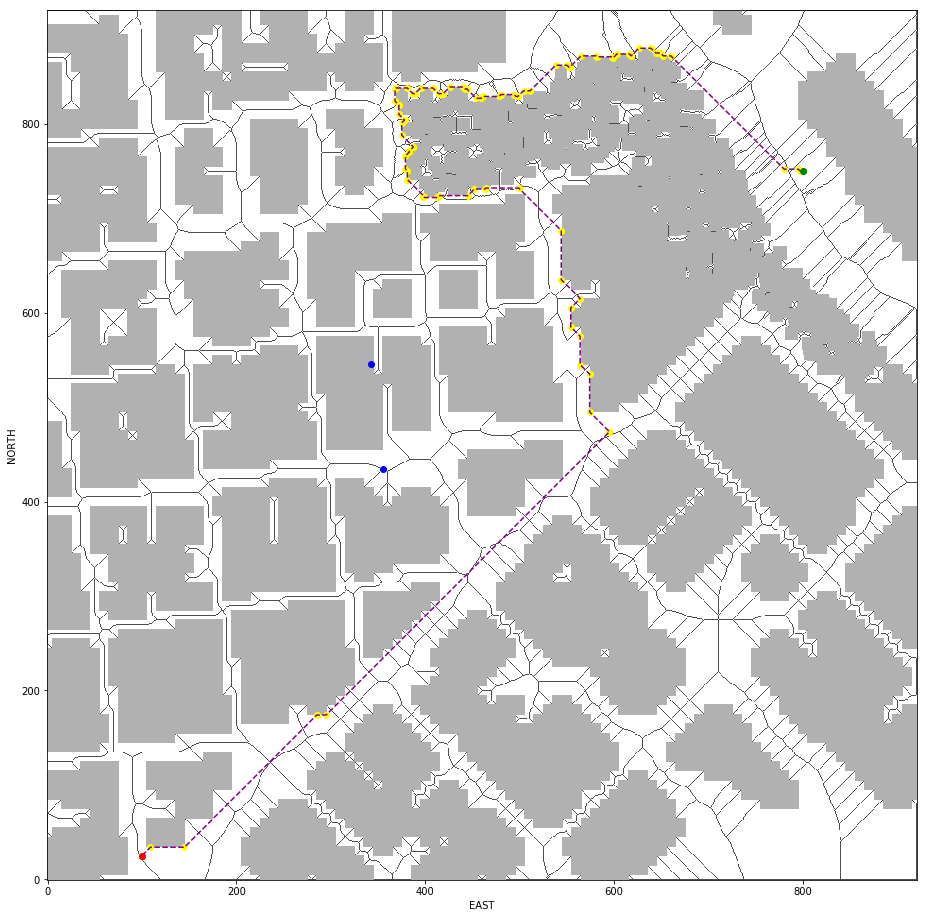

In [33]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
plt.plot(grid_start[1], grid_start[0], 'ro')
plt.plot(grid_goal[1], grid_goal[0], 'g8')
p=np.array(global_path)
pp=np.array(path)
ppp=np.array(path_a)
plt.plot(p[:, 1], p[:, 0], 'o', c='b')
plt.plot(pp[:, 1], pp[:, 0], 'o', c='yellow')
plt.plot(ppp[:, 1], ppp[:, 0], '--', c='purple')
plt.plot(grid_start[1], grid_start[0], 'ro')
plt.plot(grid_goal[1], grid_goal[0], 'g8')
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [34]:
skeleton=medial_axis(invert(grid))
_, skeleton=get_medial_axis_path(grid, grid_goal, grid_start)

Found a path.


In [22]:
voxmap=create_voxmap(data, 10)
#print(voxmap)

In [30]:
view = np.zeros(local_planner.current_view.shape, dtype=bool)

# wall along the east-west direction, with one opening
view[20, :, :] = True
view[20, :15, 4:] = False
view[20, :, 9:] = False
start = np.array([45, 10, 10])
goal = np.array([0, 40, 10])
path, _ = a_star_3D(view, euclidean_distance, start, goal)
path_voxels = np.zeros(view.shape, dtype=bool)
for x,y,z in path:
    path_voxels[x,y,z] = True

Found a path.


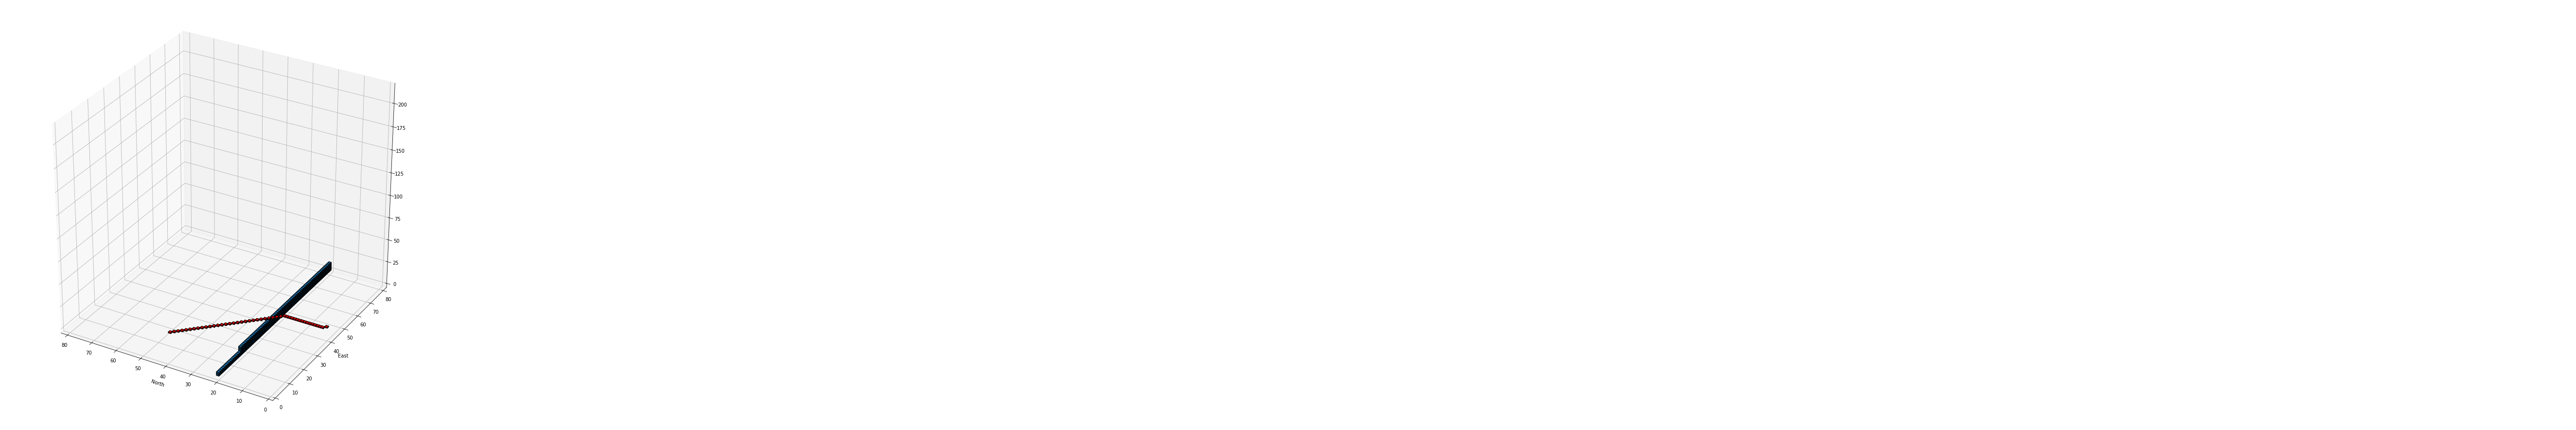

In [31]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(view, edgecolor='k')
ax.set_xlim(view.shape[0], 0)
ax.set_ylim(0, view.shape[1])
ax.set_zlim(0, view.shape[2] + 5)

v = ax.voxels(path_voxels, facecolors="red", edgecolor='k', label="path")
_ = ax.set_xlabel('North')
_ = ax.set_ylabel('East')


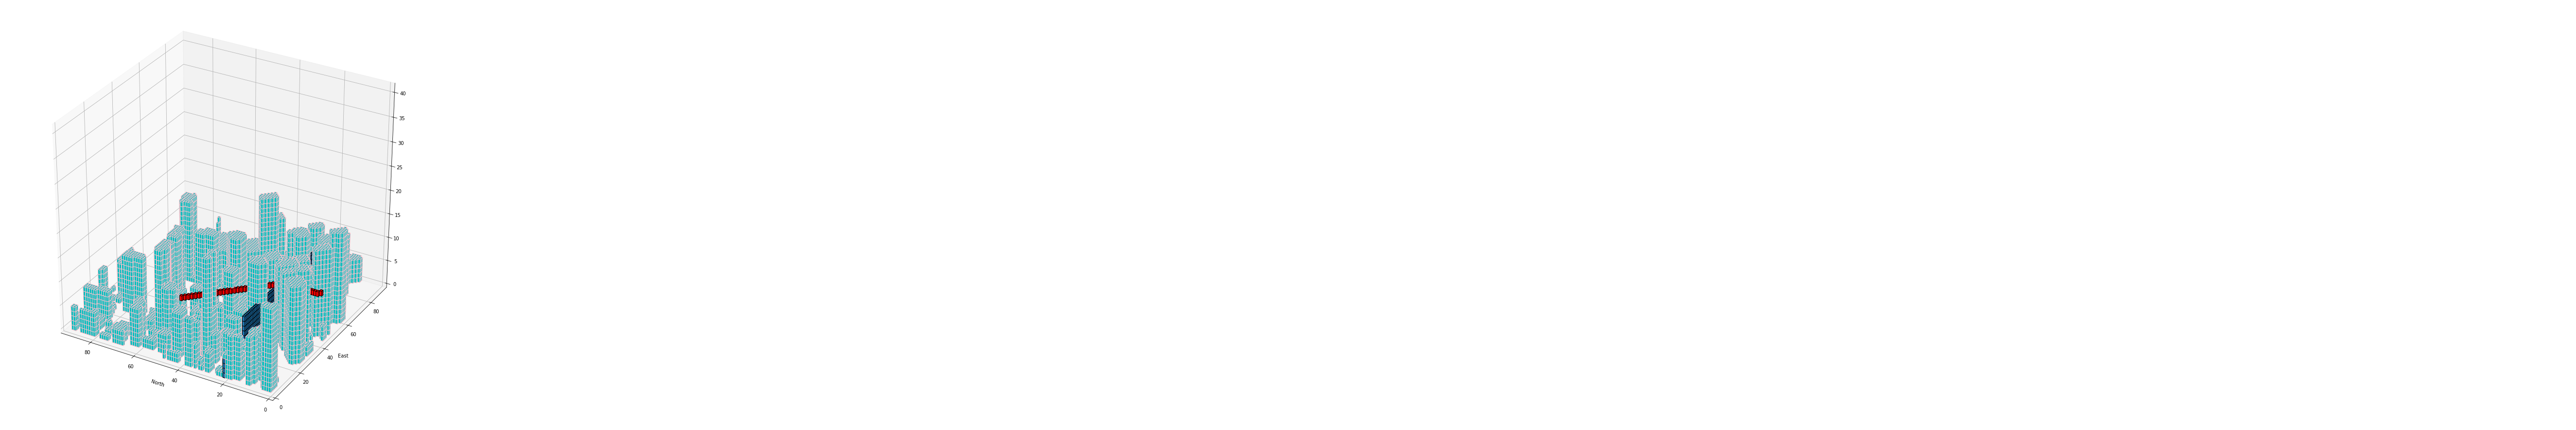

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = 16, 16
fig=plt.figure()
ax=fig.gca(projection='3d')
ax.voxels(voxmap, edgecolor='pink', facecolors='c')
ax.voxels(view,edgecolor='k')
ax.voxels(path_voxels, edgecolor='k', facecolors='red', label='path')
ax.set_xlim(voxmap.shape[0], 0)
ax.set_ylim(0, voxmap.shape[1])
ax.set_zlim(0, voxmap.shape[2]+20)
plt.xlabel('North')
plt.ylabel('East')
plt.show()

In [39]:
view = np.zeros(local_planner.current_view.shape, dtype=bool)

# wall along the east-west direction, with one opening
view[40, 20:, :] = True
view[20, :15, 4:] = False
view[20, :, 9:] = False
start = np.array([80, 60, 10])
goal = np.array([10, 0, 10])
path, _ = a_star_3D(view, euclidean_distance, start, goal)
path_voxels = np.zeros(view.shape, dtype=bool)
for x,y,z in path:
    path_voxels[x,y,z] = True

Found a path.


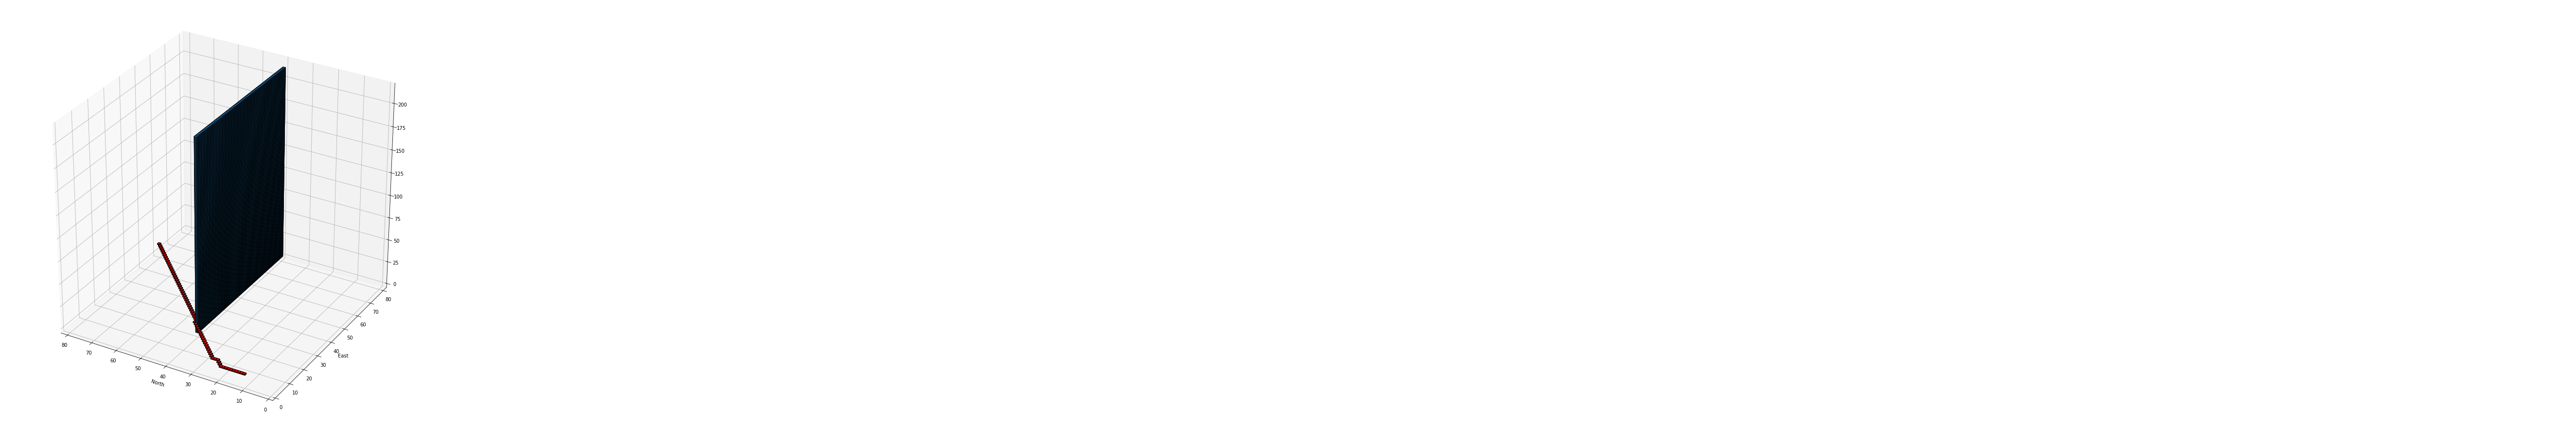

In [40]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(view, edgecolor='k')
ax.set_xlim(view.shape[0], 0)
ax.set_ylim(0, view.shape[1])
ax.set_zlim(0, view.shape[2] + 5)

v = ax.voxels(path_voxels, facecolors="red", edgecolor='k', label="path")
_ = ax.set_xlabel('North')
_ = ax.set_ylabel('East')

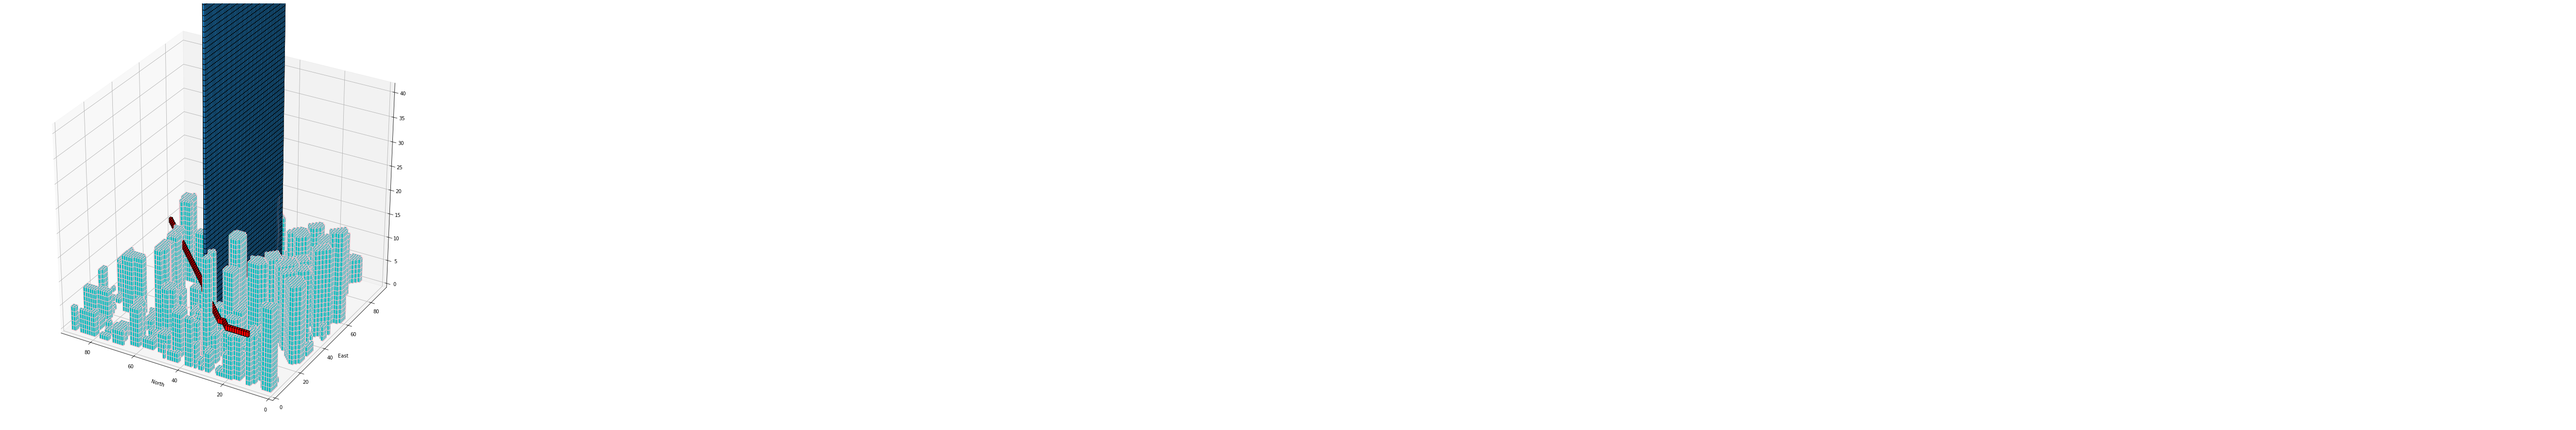

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = 16, 16
fig=plt.figure()
ax=fig.gca(projection='3d')
ax.voxels(voxmap, edgecolor='pink', facecolors='c')
ax.voxels(view,edgecolor='k')
ax.voxels(path_voxels, edgecolor='k', facecolors='red', label='path')
ax.set_xlim(voxmap.shape[0], 0)
ax.set_ylim(0, voxmap.shape[1])
ax.set_zlim(0, voxmap.shape[2]+20)
plt.xlabel('North')
plt.ylabel('East')
plt.show()

In [43]:
view = np.zeros(local_planner.current_view.shape, dtype=bool)

# wall along the east-west direction, with one opening
view[8, :, :] = True
view[8, :15, 4:] = False
view[8, :, 9:] = False

start = np.array([35, 5, 1])
goal = np.array([0, 20, 1])
path, _ = a_star_3D(view, euclidean_distance, start, goal)
path_voxels = np.zeros(view.shape, dtype=bool)
for x,y,z in path:
    path_voxels[x,y,z] = True

Found a path.


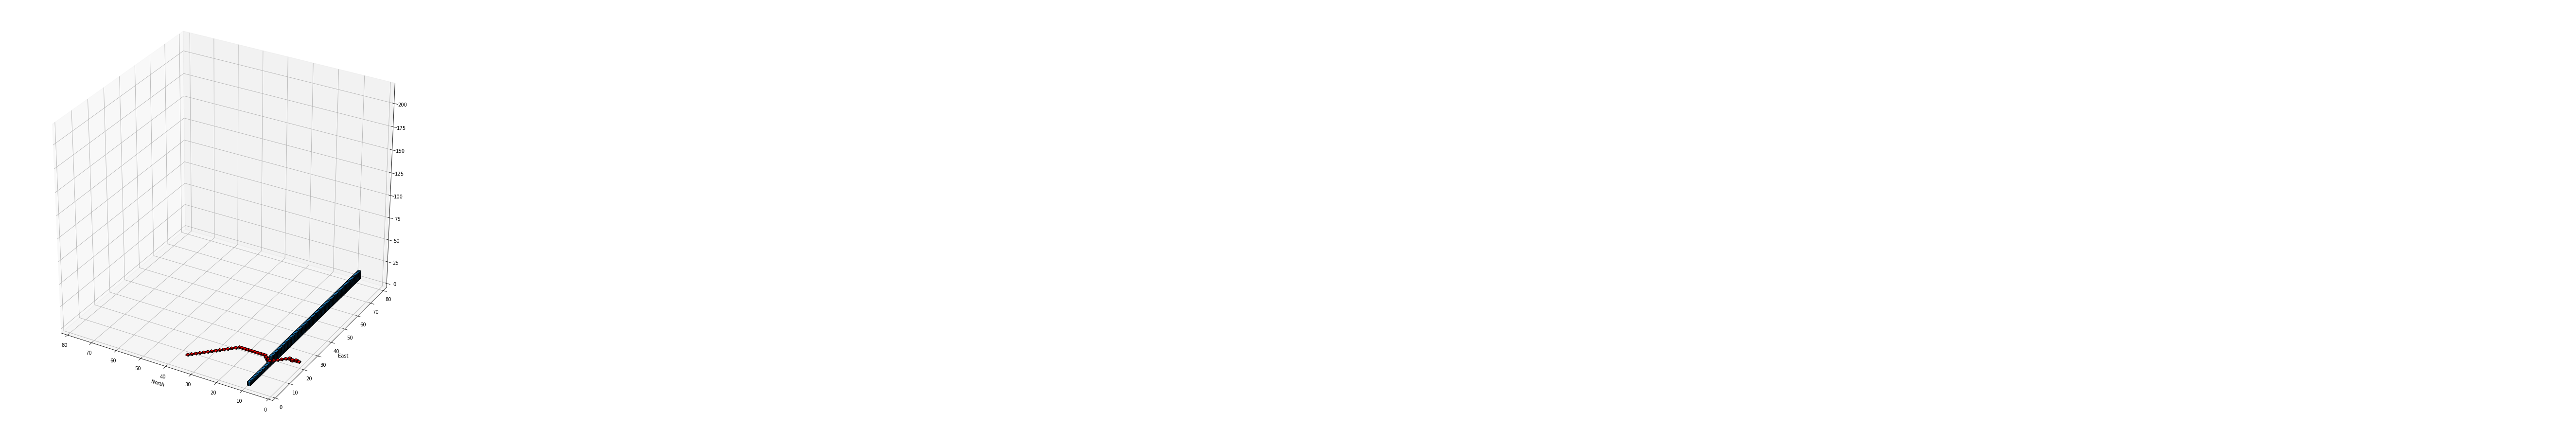

In [44]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(view, edgecolor='k')
ax.set_xlim(view.shape[0], 0)
ax.set_ylim(0, view.shape[1])
ax.set_zlim(0, view.shape[2] + 5)

v = ax.voxels(path_voxels, facecolors="red", edgecolor='k', label="path")
_ = ax.set_xlabel('North')
_ = ax.set_ylabel('East')

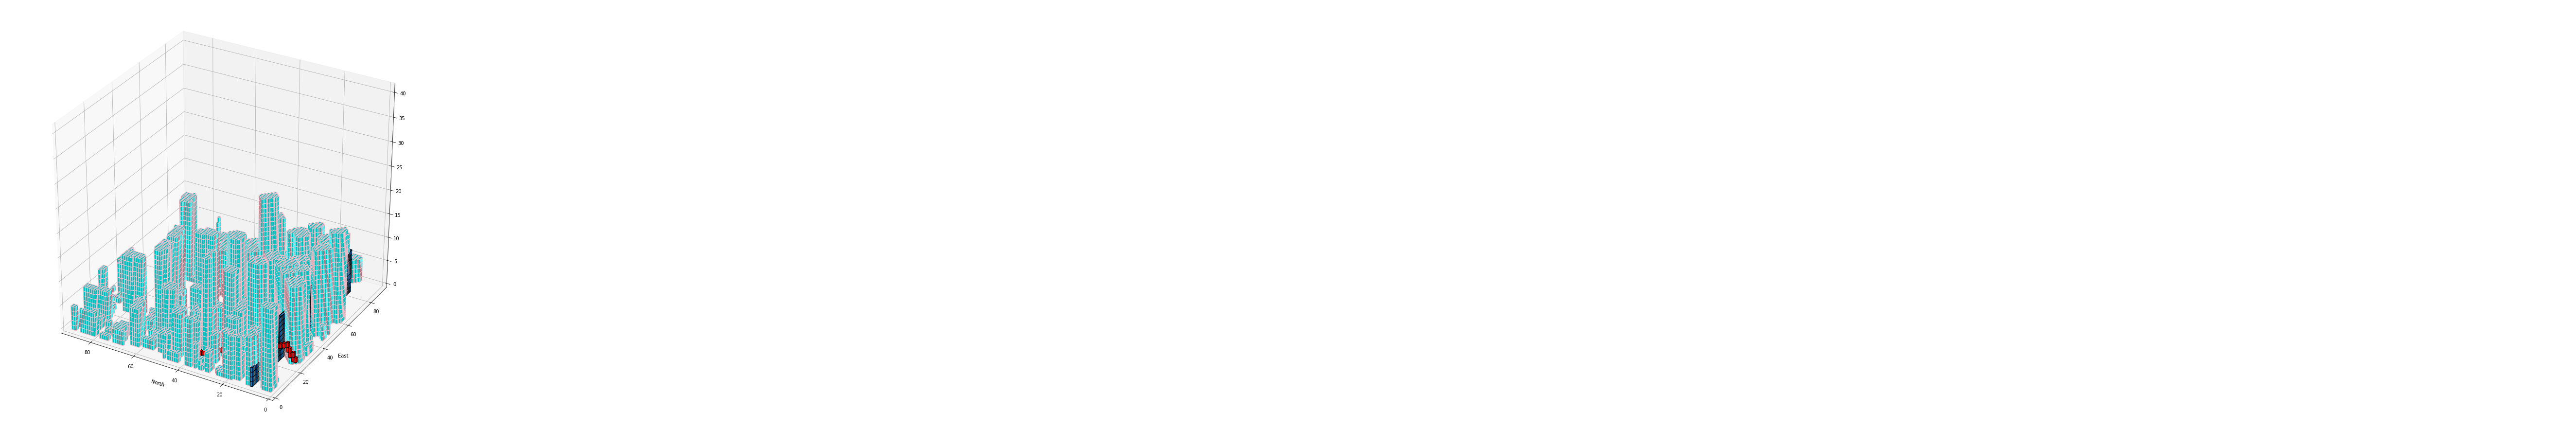

In [45]:
plt.rcParams['figure.figsize'] = 16, 16
fig=plt.figure()
ax=fig.gca(projection='3d')
ax.voxels(voxmap, edgecolor='pink', facecolors='c')
ax.voxels(view,edgecolor='k')
ax.voxels(path_voxels, edgecolor='k', facecolors='red', label='path')
ax.set_xlim(voxmap.shape[0], 0)
ax.set_ylim(0, voxmap.shape[1])
ax.set_zlim(0, voxmap.shape[2]+20)
plt.xlabel('North')
plt.ylabel('East')
plt.show()

In [5]:
global_home = [lon0, lat0, 0.]
global_position=np.array([-122.3943410,37.7915164, 0])
current_local_pos = global_to_local(global_position, global_home)
#current_local_pos = (0, 0)

#goal_lon, goal_lat = -122.39441123, 37.79141968 # main str between mission and howard
#goal_lon, goal_lat = -122.398721, 37.7931154  # front street (a block from McDonalds)
#goal_lon, goal_lat = -122.402402, 37.795429  # top left, issue getting there with voxel map. good example for replanning
goal_lat, goal_lon = 37.796368, -122.396908 # between the trees on the north side
#goal_lat, goal_lon = 37.793245, -122.397746
#goal_lat, goal_lon = 37.793212, -122.401092 # middle left, nice long path with some narrow passages

TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5

In [6]:
global_path, data, north_offset, east_offset = get_main_plan(global_home, goal_lat, goal_lon, current_local_pos)

North offset = 316, east offset = 445
Local Goal: {0}
Local Start and Goal:  (210, 719) (747, 489)
Found a path.
number of waypoints: 609
number of waypoints after pruning: 236
number of waypoints after collinearity pruning: 236
number of waypoints after raytracing pruning: 14


In [7]:
grid, nmin, emin = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
# reverse to grid coordinates
grid_path = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in global_path]

In [8]:
grid_start = (int(current_local_pos[0] + north_offset), int(current_local_pos[1] + east_offset))
local_goal = global_to_local((goal_lon, goal_lat, 0), global_home)
grid_goal = (int(local_goal[0] + north_offset), int(local_goal[1] + east_offset))
print('Local Start and Goal: ', grid_start, grid_goal)

Local Start and Goal:  (210, 719) (747, 489)


In [9]:
_, skeleton = get_medial_axis_path(grid, grid_goal, grid_start)

Found a path.


In [10]:
global_path

[[-105, 275, 5, 0],
 [28, 166, 5, 0],
 [55, 136, 5, 0],
 [106, 116, 5, 0],
 [261, 102, 5, 0],
 [353, 84, 5, 0],
 [381, 77, 5, 0],
 [415, 70, 5, 0],
 [417, 65, 5, 0],
 [417, 63, 5, 0],
 [418, 62, 5, 0],
 [418, 58, 5, 0],
 [429, 47, 5, 0],
 [431, 44, 5, 0]]

In [11]:
from matplotlib import collections as mc

def plot_local_path(local_planner, grid, grid_path, ax=None, local_path=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(7, 7))    
    E, N = 1, 0
    _ = ax.plot(local_planner.grid_position[1], local_planner.grid_position[0], 'ro', label="current position")
    _ = ax.plot(local_planner.grid_next_waypoint[1], local_planner.grid_next_waypoint[0], 'x', c="orange", label="next global waypoint")

    if local_path is None:
        lines = [((local_planner.grid_position[1], local_planner.grid_position[0]),
                  (local_planner.grid_next_waypoint[1], local_planner.grid_next_waypoint[0]))]
        lc = mc.LineCollection(lines, colors="green", linewidths=2)
        ax.add_collection(lc)

    for p1, p2 in local_planner.grid_local_box:    
        ax.plot([p1[1], p2[1]], [p1[0], p2[0]], alpha=0.7, c="blue", linewidth=1, solid_capstyle='round', zorder=2, label="local view")
        #ax.plot([p1[E], p2[E]], [p1[N], p2[N]], 'o', zorder=1)

    ax.plot(local_planner.grid_local_goal[1], local_planner.grid_local_goal[0], 'rx', label="local goal")  
    
    xlim = (min([local_planner.ymin, local_planner.grid_position[1], local_planner.grid_next_waypoint[1]]) - 10,
            max([local_planner.ymax, local_planner.grid_position[1], local_planner.grid_next_waypoint[1]]) + 10)
    ylim = (min([local_planner.xmin, local_planner.grid_position[0], local_planner.grid_next_waypoint[0]]) - 10,
            max([local_planner.xmax, local_planner.grid_position[0], local_planner.grid_next_waypoint[0]]) + 10)  
        
    ax.imshow(grid, origin='lower', cmap='Greys') 
    pp = np.array(grid_path)
    ax.plot(pp[:,1], pp[:,0], '--', c="orange", label="global path")
    
    if local_path is not None:
        local_pp = np.array(local_path)
        ax.plot(local_pp[:,1], local_pp[:,0], '-', c="red", label="local path")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #ax.set_title("Local Planning 2D View")
    ax.set_xlabel("East")
    ax.set_ylabel("North")
    ax.legend(loc="best")

In [12]:
from mpl_toolkits.mplot3d import Axes3D

def plot_local_path_3d(local_planner, local_path=None, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    current_view = local_planner.current_view
    ax.voxels(current_view, edgecolor='k')
    ax.set_xlim(current_view.shape[0], 0)
    ax.set_ylim(0, current_view.shape[1])
    ax.set_zlim(0, current_view.shape[2] )

    #trajectory = np.array([local_planner.grid_voxel_current_position, local_planner.grid_voxel_local_goal])
    #ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2])
    if local_path is not None:
        v = ax.voxels(local_planner.path_voxels(local_path), facecolors="red", edgecolor='k', label="path")
    _ = ax.set_xlabel('North')
    _ = ax.set_ylabel('East')
    #_ = ax.set_title("Local Planning 3D View")

In [13]:
def plot_local_planning_2d_and_3d(local_planner, grid, grid_path, local_waypoints=None, local_voxel_path=None, figsize=(14,7), filename=None):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d') 
    plot_local_path(local_planner, grid, grid_path, ax=ax1, local_path=local_waypoints)
    plot_local_path_3d(local_planner, ax=ax2, local_path=local_voxel_path)
    if filename is not None:
        plt.savefig(filename)

In [15]:
i = 0
j = 0
global_path_stack = Queue()
[global_path_stack.put(p) for p in global_path]

current_position = current_local_pos
#next_waypoint = global_path_stack.get()
voxel_size = 2
max_altitude = 10

local_planner = Local3DPlanner(global_path_stack, data, north_offset, east_offset, voxel_size, TARGET_ALTITUDE, max_altitude)

In [16]:
local_planner.update_position(current_position)
local_path, local_voxel_path = local_planner.plan()
grid_local_path = [tuple(np.array(p) + np.array([north_offset, east_offset, 0, 0]))  for p in local_path]

waypoint inside current view, moving on to next waypoint [ 28 166   5]
Found a path.


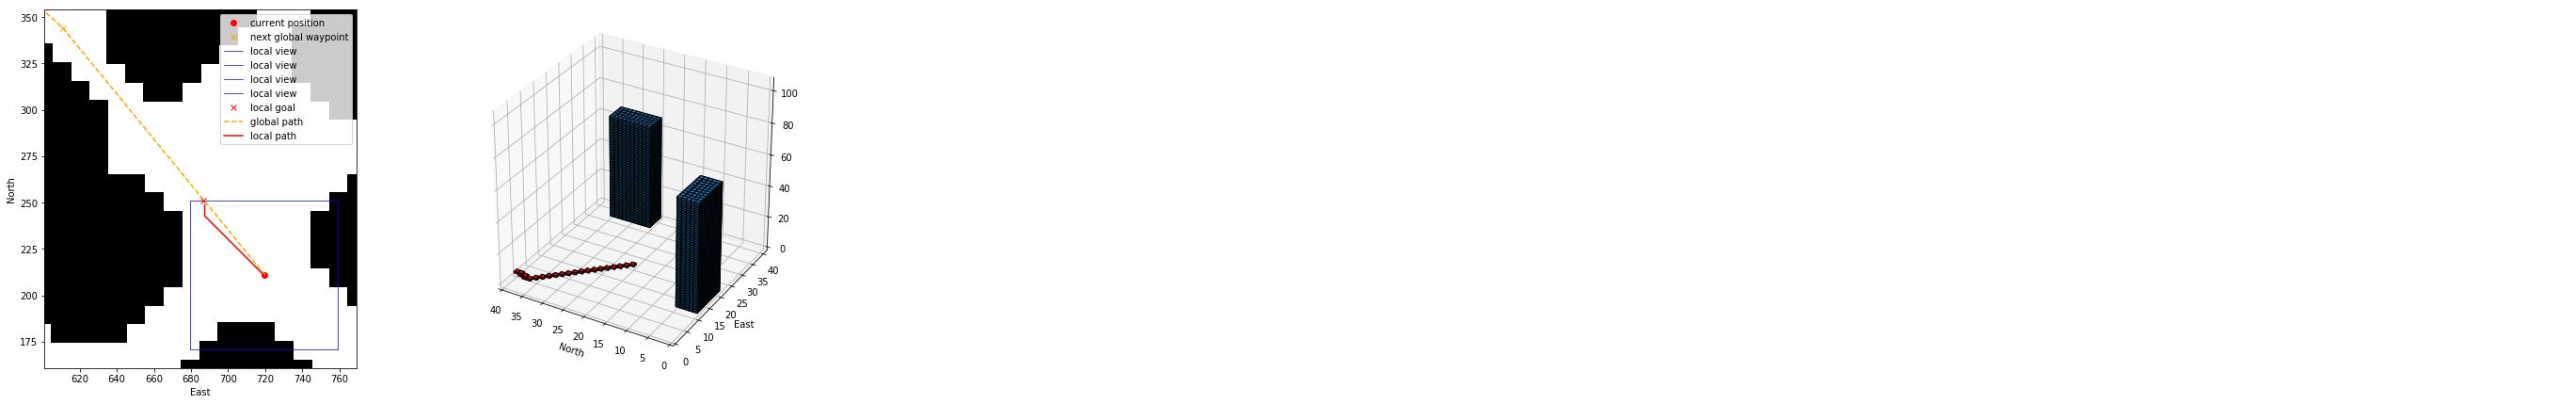

In [17]:
plot_local_planning_2d_and_3d(local_planner, grid, grid_path, local_waypoints=grid_local_path, local_voxel_path=local_voxel_path, figsize=(15,7))

#### End to End Local Planning
comment out plot_local_planning_2d_and_3d to generate plots for each local planning step. png files are written to the local_planning folder

Found a path.
Found a path.
Found a path.
waypoint inside current view, moving on to next waypoint [ 55 136   5]
Found a path.
waypoint inside current view, moving on to next waypoint [106 116   5]
Found a path.
waypoint inside current view, moving on to next waypoint [261 102   5]
Found a path.
Found a path.
Found a path.
Found a path.
waypoint inside current view, moving on to next waypoint [353  84   5]
Found a path.
Found a path.
waypoint inside current view, moving on to next waypoint [381  77   5]
Found a path.
waypoint inside current view, moving on to next waypoint [415  70   5]
Found a path.
waypoint inside current view, moving on to next waypoint [417  65   5]
waypoint inside current view, moving on to next waypoint [417  63   5]
waypoint inside current view, moving on to next waypoint [418  62   5]
waypoint inside current view, moving on to next waypoint [418  58   5]
waypoint inside current view, moving on to next waypoint [429  47   5]
waypoint inside current view, moving 

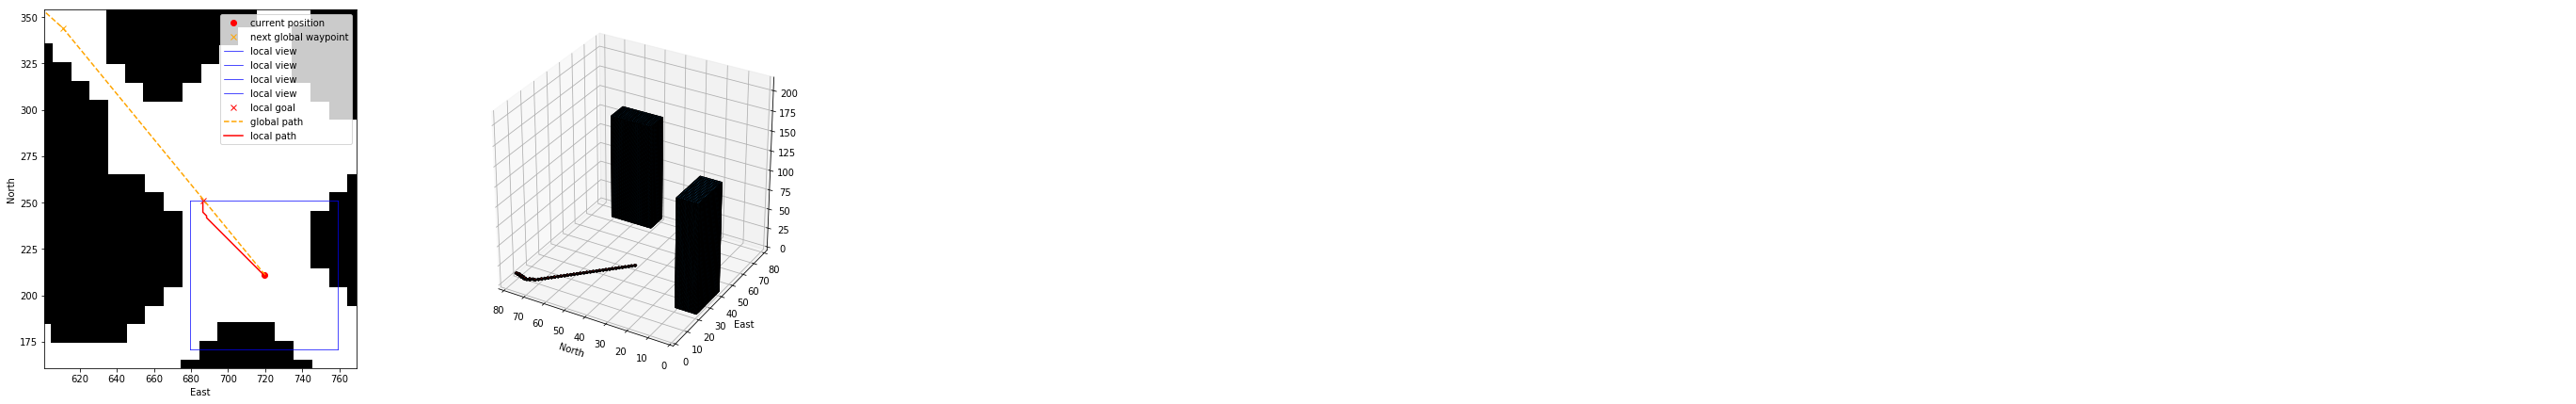

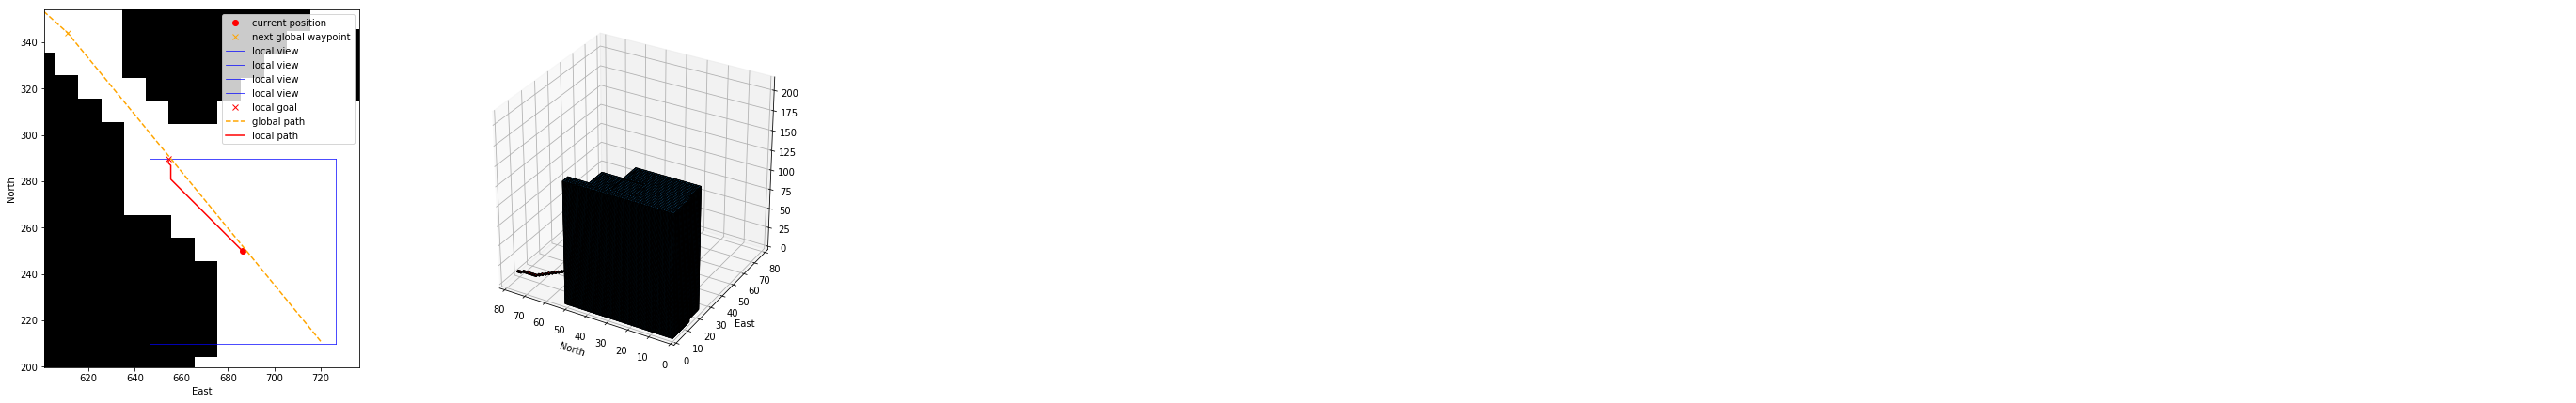

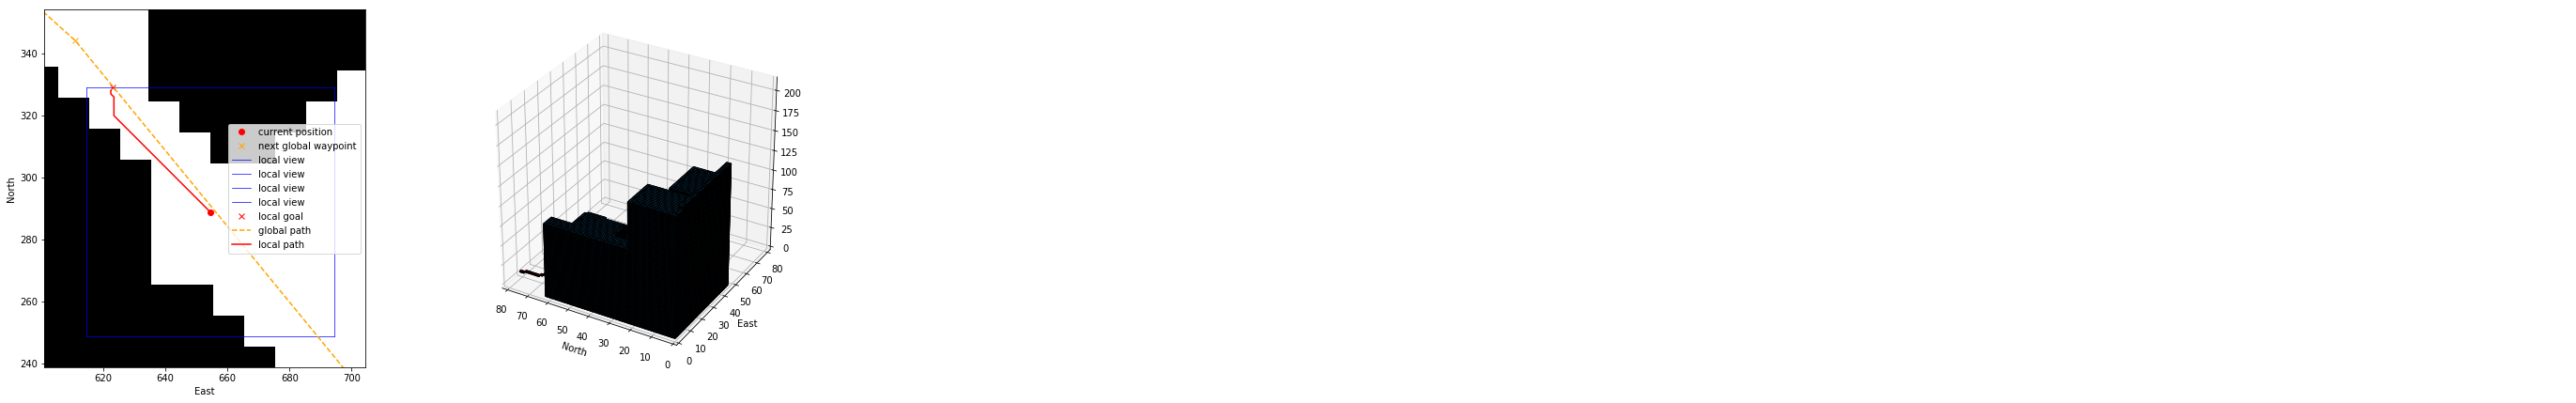

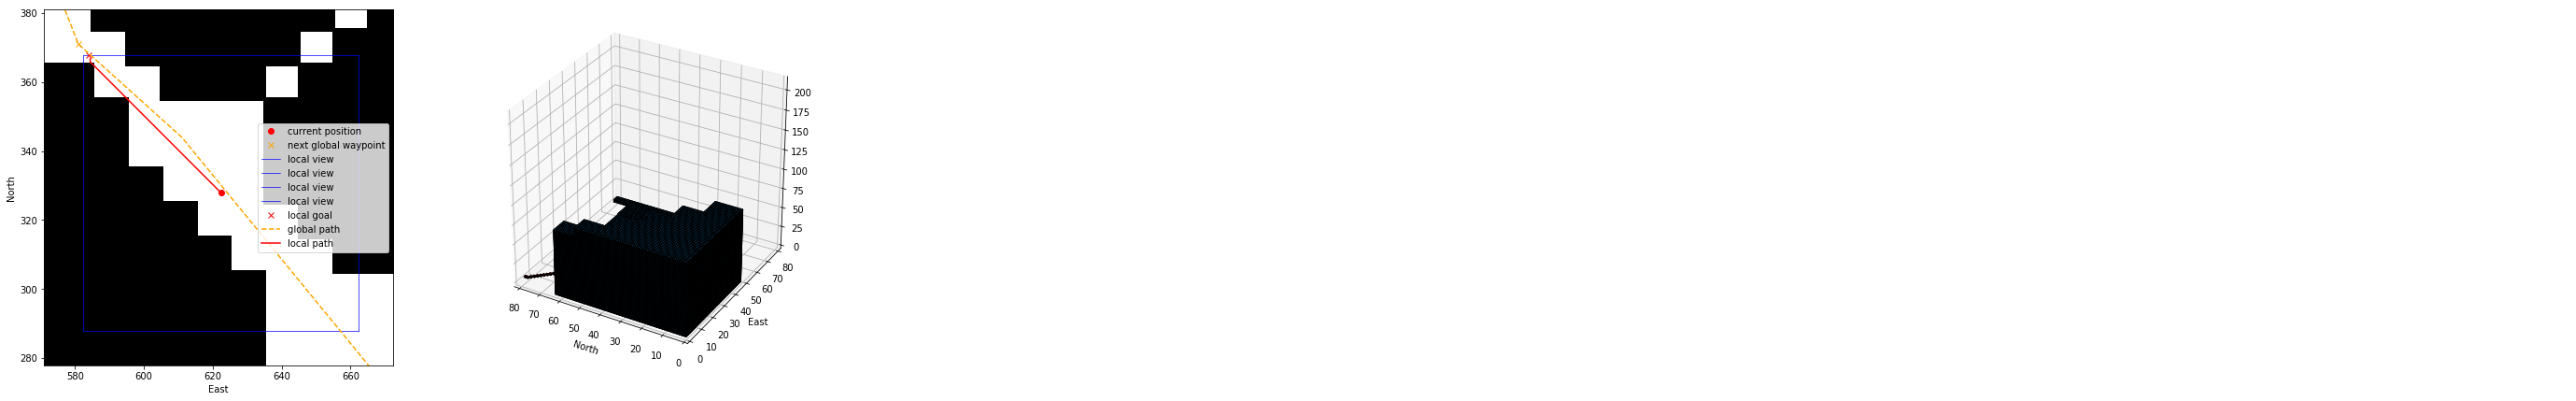

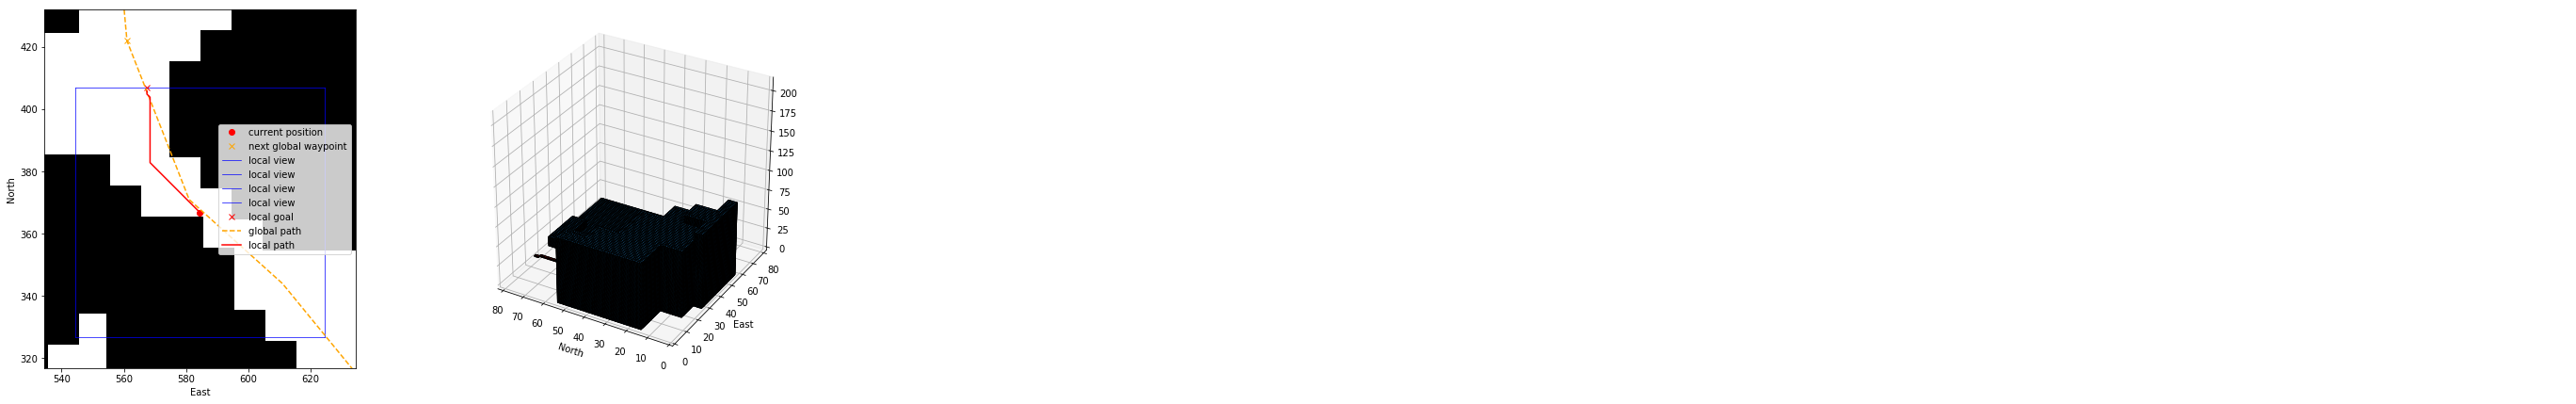

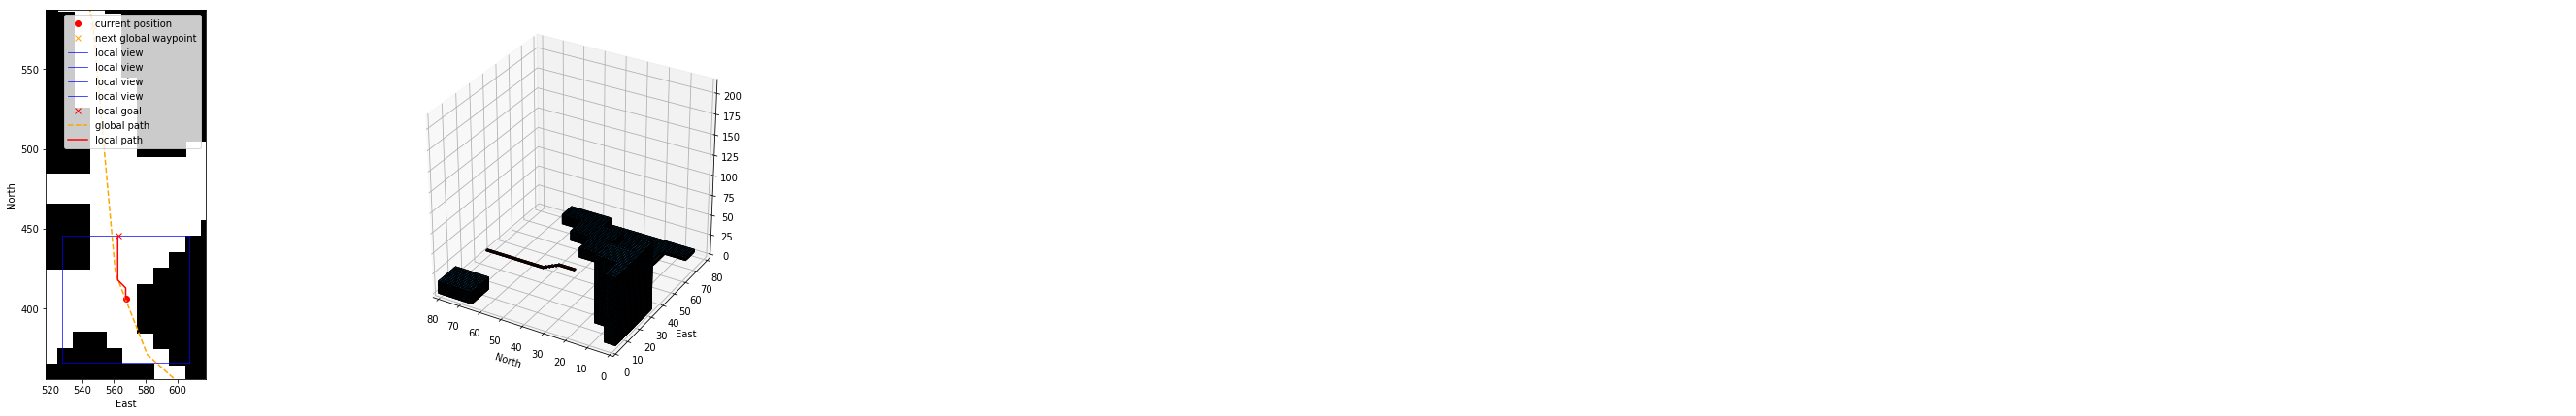

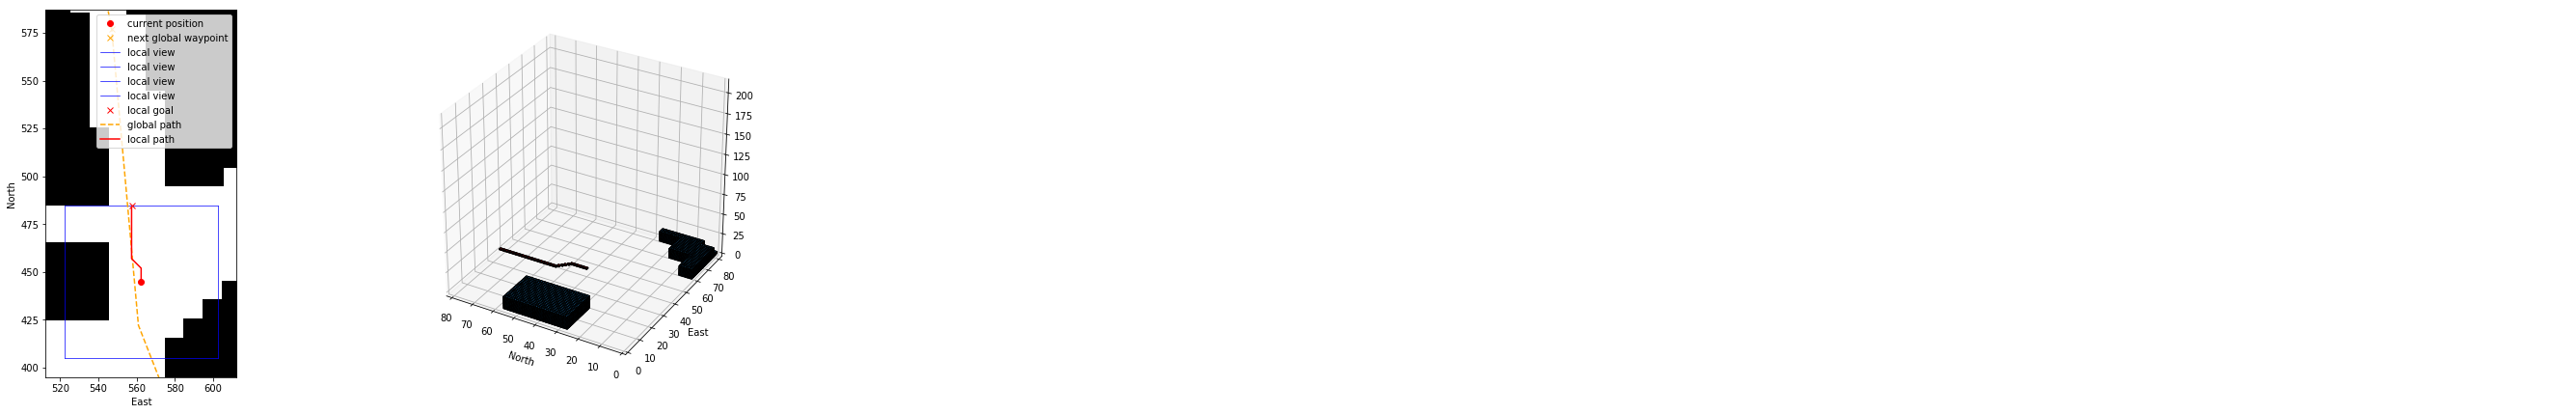

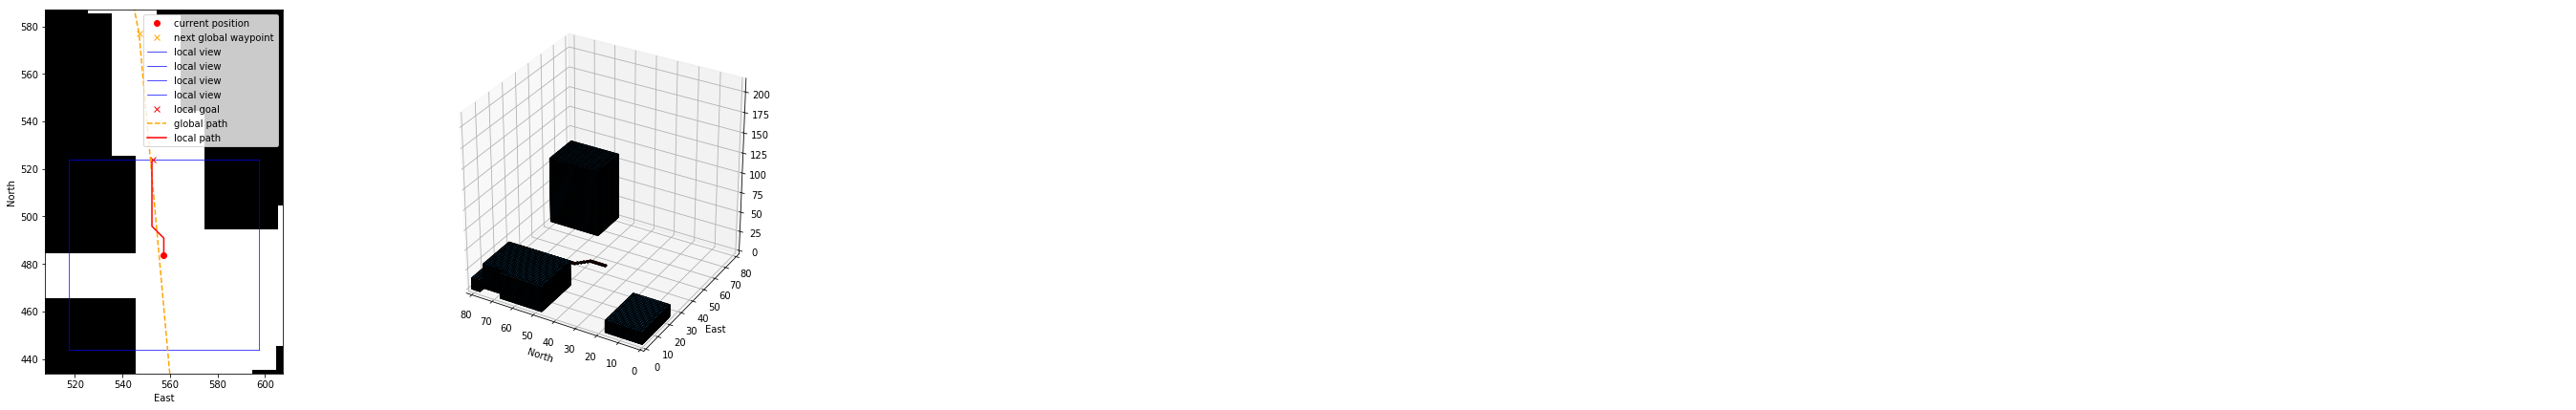

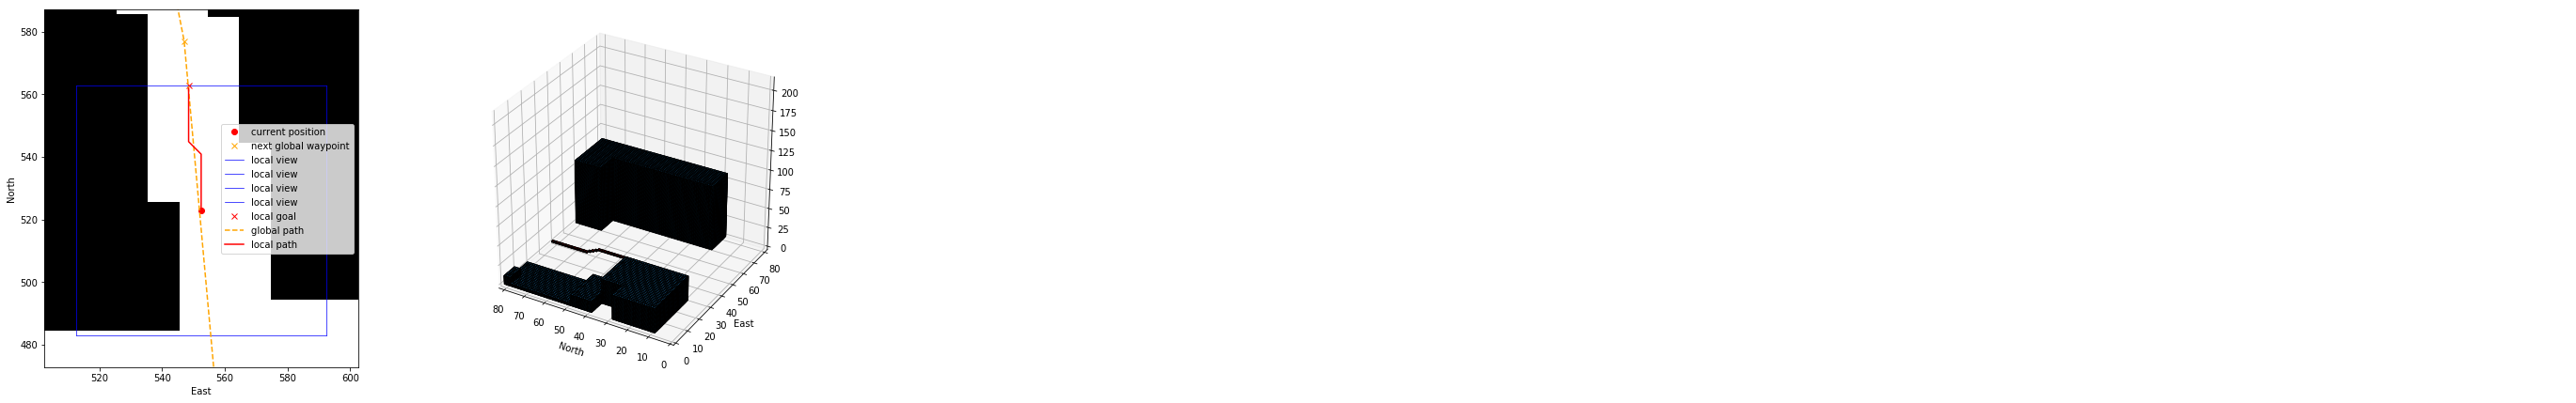

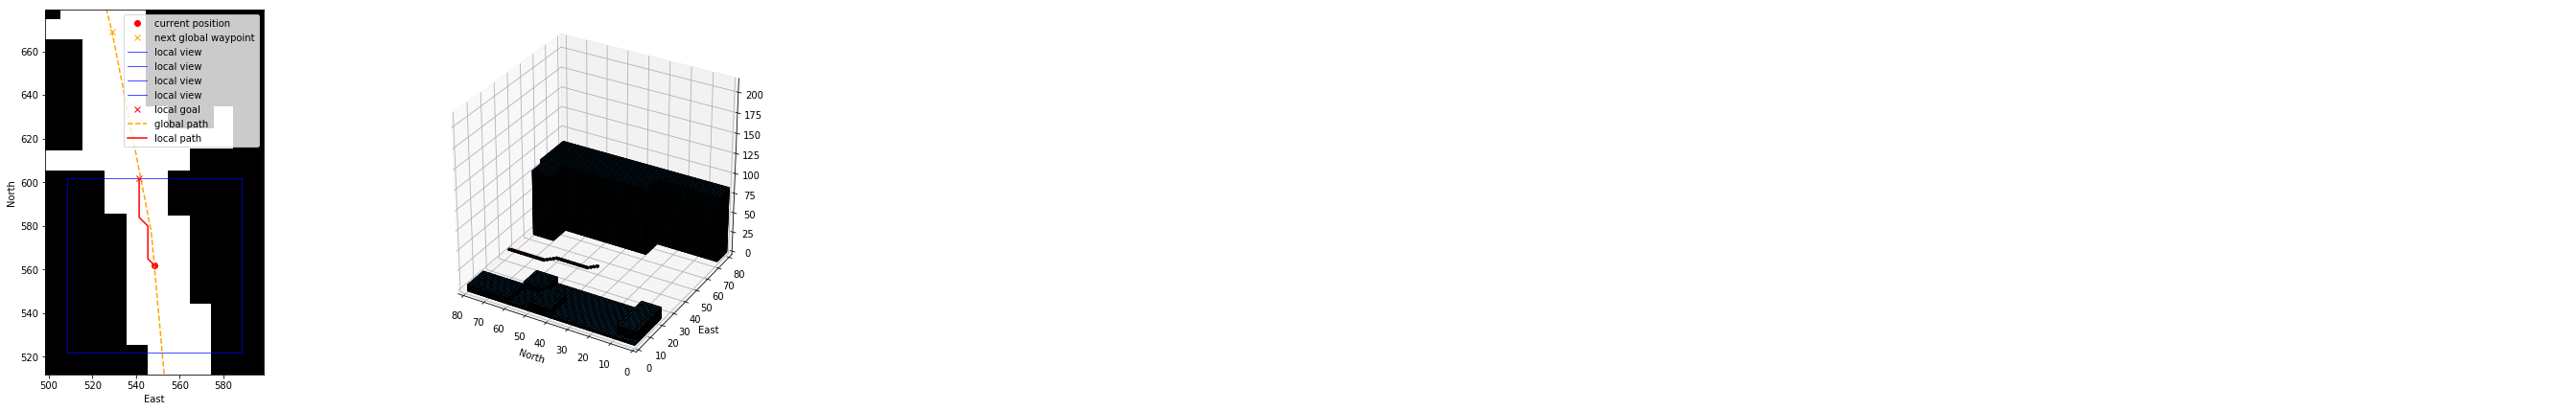

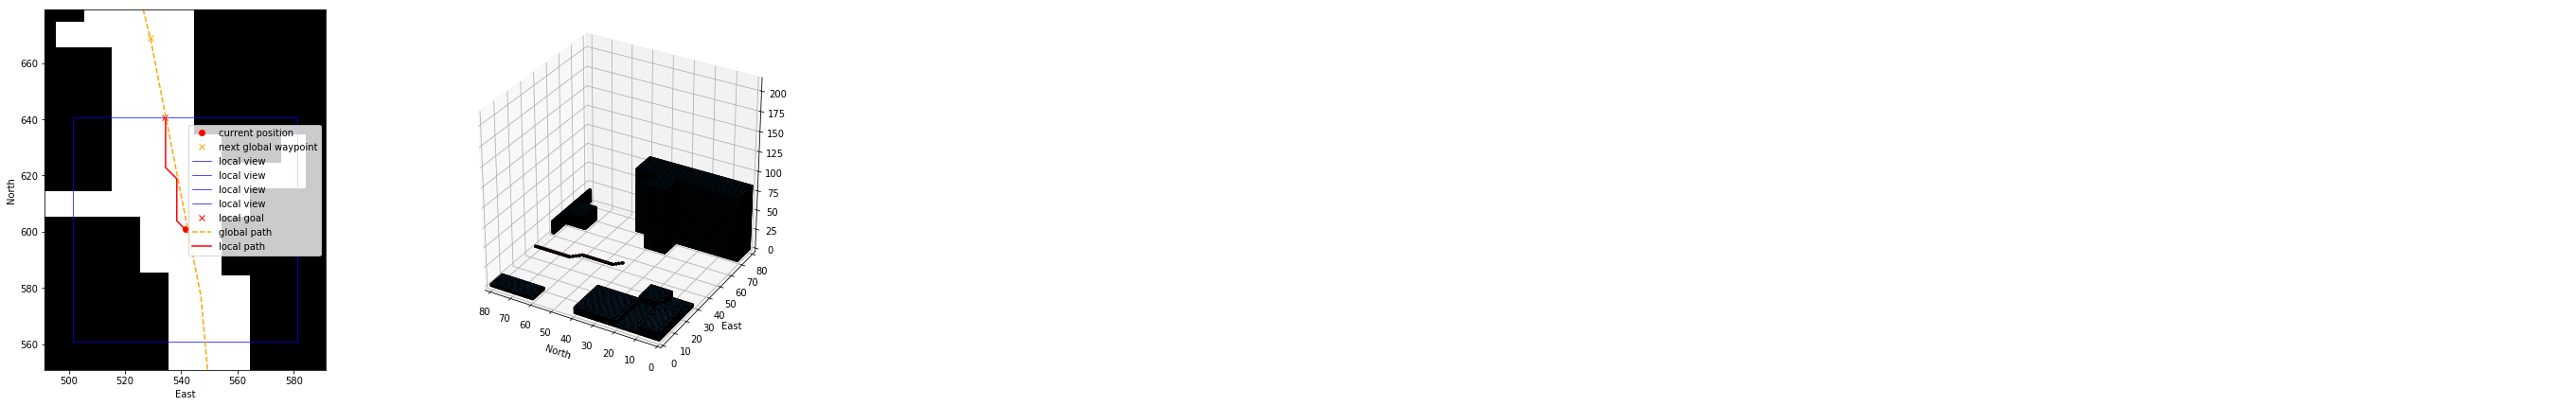

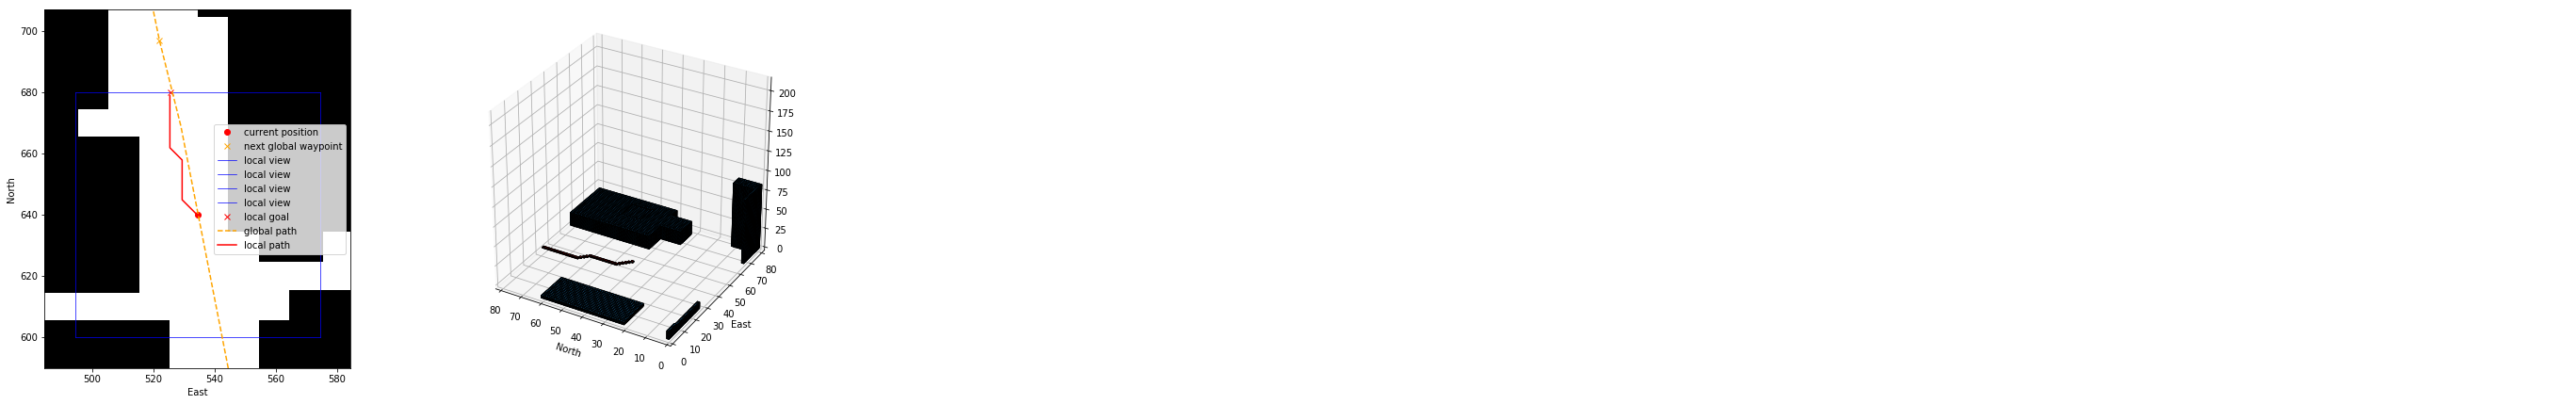

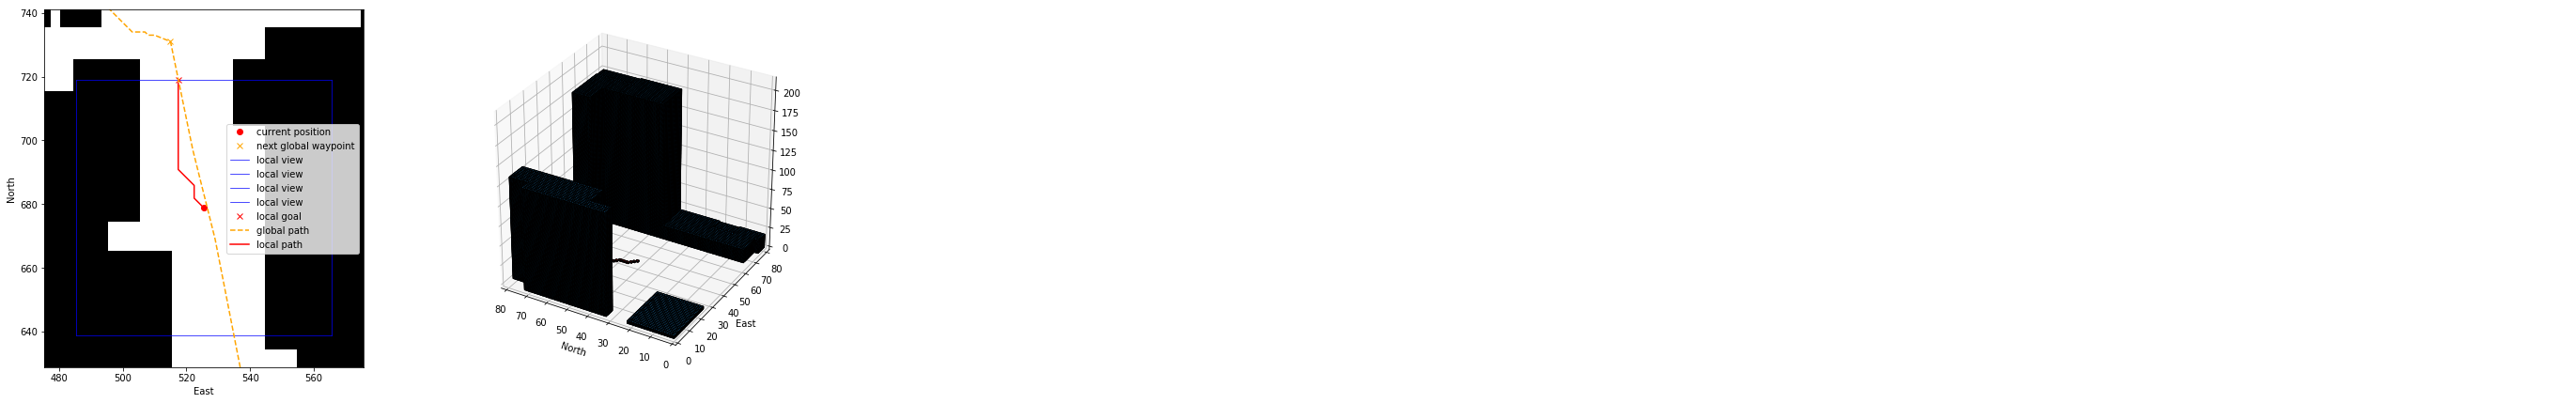

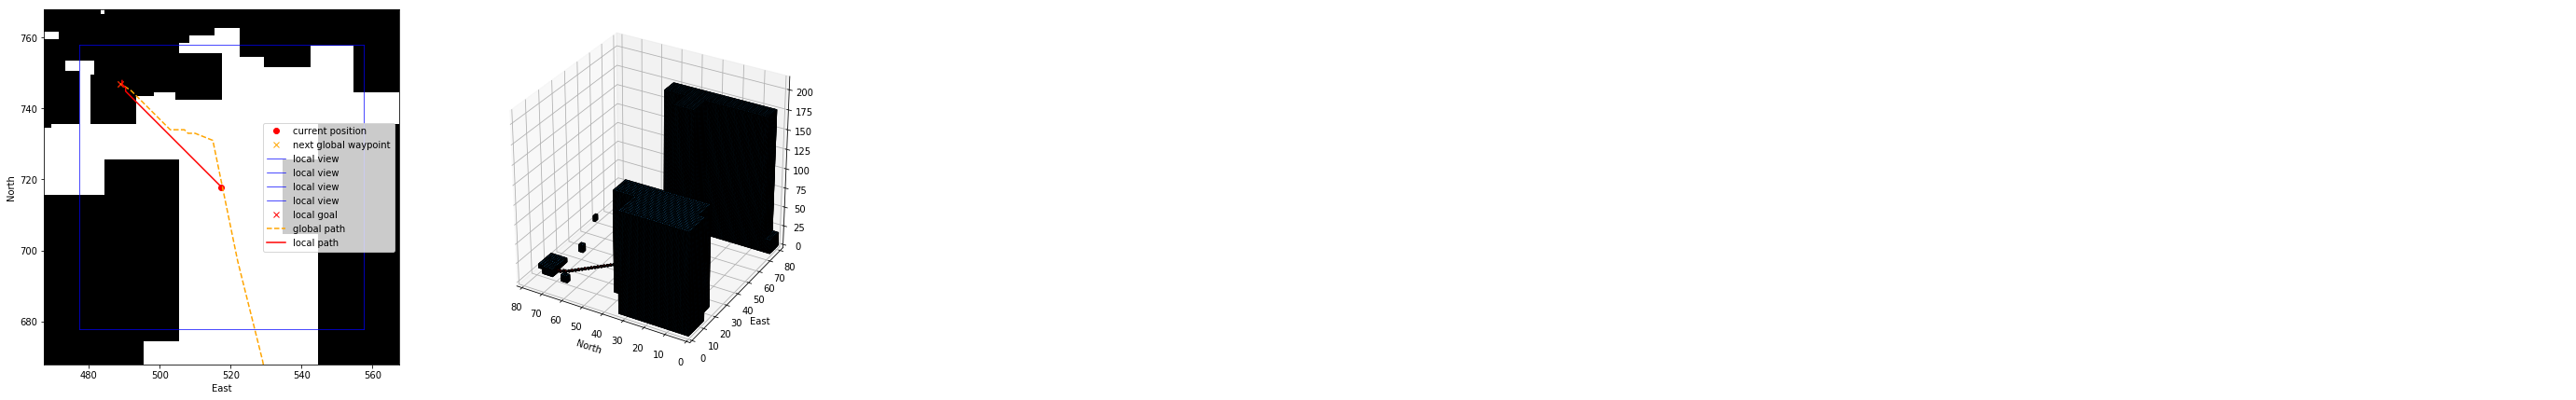

In [19]:
import queue
i = 0
global_path_stack = queue.Queue()
[global_path_stack.put(p) for p in global_path]
current_position = current_local_pos
next_waypoint = global_path_stack.get()
voxel_size = 1
max_altitude = 10
local_planner = Local3DPlanner(global_path_stack, data, north_offset, east_offset, voxel_size, TARGET_ALTITUDE, max_altitude)

while not local_planner.waypoint_queue.empty():    
    local_planner.update_position(current_position)
    local_path, local_voxel_path = local_planner.plan()
    grid_local_path = [tuple(np.array(p) + np.array([north_offset, east_offset, 0, 0]))  for p in local_path]
    plot_local_planning_2d_and_3d(local_planner, grid, grid_path, local_waypoints=grid_local_path, local_voxel_path=local_voxel_path, figsize=(15,7), filename=None)    
    # set current position to last point of local path
    current_position = local_path[-1][:3]
    i+=1